# Predicting SAP stock prices
## Using PyTorch and SageMaker

---


## Instructions

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Part 1: Data preparation
  1. Downloading data
  2. Prepare the data
  3. Divide into training and testing set
  4. Scale/Normalize the data
  5. Save the data
2. Part 2: Local training and testing
  1. Define a network model
  1. Run training inside the notebook
  2. Get insights regarding training quality
3. Part 3: Use AWS for training and prediction
  1. Prepare custom code for 
    1. Neural network model
    2. Training
  2. Upload the processed data to S3
  3. Train the model on a separate GPU-optimized instance
  4. Deploy the trained model on a separate instance
  5. Use the model for predictions
  6. Cleanup


# Disclaimer

This is notebook is meant to demonstrate selected abilities of AWS in field of Machine Learning. 

Neural network used in this notebook is not optimized for prediction of stock prices. 
In fact, its predictions are very low quality. Predicting stock prices is a very difficult task! 
**Do not invest any money into stock based on these predictions**


# Part 1: Data Preparation

## Section 1.1: Downloading data

We use the historical data from a polish provider Stooq.

Visit https://stooq.com/q/d/?s=sap.de to fine-tune the data.

In [1]:
import numpy as np
import pandas as pd

# Global settings
use_sinus_data = False  # Replaces stock price with syntetic sinus curve - to debug training and prediction

forecast_days = 1       # How many days to the future shall the stock price be predicted
                        # For example: forecasting 2 days to the future will use the data from last days
                        # to predict the price on a day 2 days ahead, but will not predict the price 1 day ahead

Selected commands similar to regular Linux commands can be used in the notebook.
These commands are called *line magics*. List of available magics looks like this:

In [2]:
% lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

Regular Linux shell command can be run as well by preceeding them with exclamation mark: `!`

We use these tools to download the data from the source and store it in csv file

In [3]:
%mkdir -p "data"
# Clean existing data if necessary
!rm -rf "data/*"

!curl -k -sS "https://stooq.com/q/d/l/?s=sap.de&i=d" > "data/data.raw.csv"
# i=d - interval daily (other: w,m,q,y - week, month, quarter, year)
# o=1100000 - options - binary mask 
# other...

We may want to start learning with simpler data, so here is the option to replace stock prices with `sin` signal

In [4]:
def create_target_for_supervised(src, target, shift=1):
    """
    This function shifts target forward by `shift` positions with respect to the src
    Example for shift=1:
    [a,b,c] [a,b,c] -> [a,b,c] [x,a,b]
    """
    src = pd.DataFrame(src)
    target = pd.DataFrame(target)
    
    src = src.iloc[:(shift * -1)]
    target = target.iloc[shift:]
    
    # Data was shifted and 'empty spaces' in form of NaNs emerged
    # We may fill it with zeros:
    # src.fillna(0, inplace=True)
    # or interpolate
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
    src.interpolate(method='nearest', inplace=True)
    target.interpolate(method='nearest', inplace=True)
    
    src.reset_index(inplace=True, drop=True)
    target.reset_index(inplace=True, drop=True)

    return src, target

def replace_stock_data_with_sine(input_data, target_data):
    """
    Replaces anything in input_data and target_data with a sine signal. 
    Length of both arrays is preserved
    """
    np.random.seed(2)

    N = len(input_data)
    L = len(input_data)
    
    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)).reshape(N, 1)
    data = np.sin(x / 3.1415 / 2.0).astype('float64')
    input_data['AvgPrice'] = data
    target_data['AvgPrice'] = data # target_data should be shifted with respect to input_data. We do it later
    input_data['Volume'] =  np.ones(N, 'float64')
    
    return input_data, target_data

## Section 1.2: Preparing and Processing the data

Default data range used at stooq is: September 1994 until today.

Let's look at the data and discard any pieces of it that are not interesting for us.

In [5]:
import os
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt

def read_stock_data(data_dir='data/'):  
    ymd_date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    return pd.read_csv(data_dir+"data.raw.csv", parse_dates=['Date'], date_parser=ymd_date_parser)
   
    
def select_columns(raw):
    input_data = pd.DataFrame({
        "AvgPrice": raw['Low'] + (raw['High'] - raw['Low'])/2
    })
    target_data = input_data.copy()
    return input_data, target_data


def plot_data(input_data, target_data, title= "no title", first_days=None):
    plt.figure(figsize=(16,5))
    x_axis = range(0,len(target_data))
    plt.title(title)
    plt.plot(x_axis[:first_days], input_data[:first_days], 'b.-', label='input')
    plt.plot(x_axis[:first_days], target_data[:first_days], 'r.-', label='target')

    plt.legend(loc='best')
    plt.show()

In [6]:
raw_data = read_stock_data()
print("Raw data imported from the source:\n ", raw_data.head(5))


Raw data imported from the source:
          Date    Open    High     Low   Close    Volume
0 1994-09-13  2.9978  3.0020  2.9978  3.0020  161888.0
1 1994-09-14  2.9910  3.0377  2.9821  3.0377  420909.0
2 1994-09-16  3.0576  3.0576  3.0576  3.0576   97134.0
3 1994-09-20  3.0576  3.0576  3.0576  3.0576   48566.0
4 1994-09-21  3.0576  3.0576  3.0576  3.0576  161888.0


We requre two columns of data containing the price of the stock. 
We calculate an average stock price based on the maximun and minimun from a given day.
Rest of the data is discarded. 

First column should contain input, whereas the second column contains the target.
The target column should be shifted forward by `forecast_days` in resprect to the input column.

In [7]:
input_data, target_data = select_columns(raw_data)

if use_sinus_data:
    input_data, target_data = replace_stock_data_with_sine(input_data, target_data)

input_data, target_data = create_target_for_supervised(input_data, target_data, forecast_days)

print("Shape of input:\n", input_data.shape)
print("Shape of target:\n", target_data.shape)

print("Head of input:\n", input_data.head(5))
print("Head of target:\n", target_data.head(5))

Shape of input:
 (6050, 1)
Shape of target:
 (6050, 1)
Head of input:
    AvgPrice
0    2.9999
1    3.0099
2    3.0576
3    3.0576
4    3.0576
Head of target:
    AvgPrice
0    3.0099
1    3.0576
2    3.0576
3    3.0576
4    3.0933


Plotting the data provides a chart depicting that the shift has succeeded. 
For any given day, the red curve represents the price of the stock from the next day.

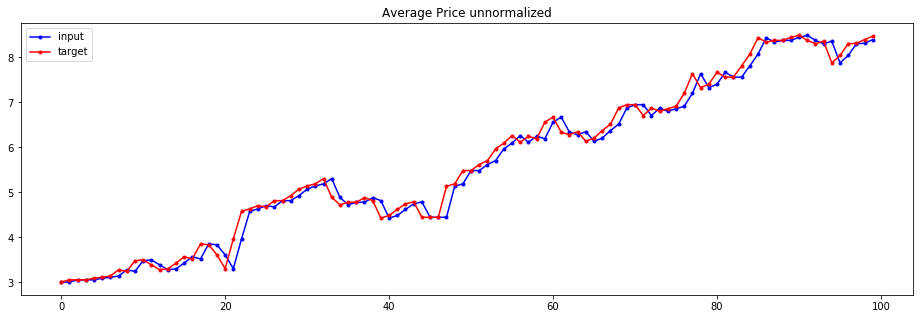

In [8]:
plot_data(input_data['AvgPrice'], target_data['AvgPrice'], "Average Price unnormalized", first_days=100)

We expect that both columns contain only numbers, thus we check if any `NaN`s or `None`s are present in the data.

In [9]:
# Check if data is clean
# Check for NaN, None, and other non-numerical data
print("There are {} null values in input".format(input_data.isnull().values.sum()))
print("There are {} null values in target".format(target_data.isnull().values.sum()))

# In case any NaNs or Nones are found, we query for their indexes
columns = input_data.columns.values.tolist()
for column in columns:
    index = input_data[column].index[input_data[column].apply(np.isnan)]
    print('Index {} in column {} is NaN or Null'.format(index,column))

There are 0 null values in input
There are 0 null values in target
Index Int64Index([], dtype='int64') in column AvgPrice is NaN or Null


## Section 1.3: Divide Data into multiple sets

Now we divide the data into two sets: training and testing.

The training data set will be fed into network to train it.
After training is complete, the test data set will be used to evaluate how well the network has been trained.

### Datasets: Training, Validation, Test

**Note**: Usually the data is divided onto three datasets: training, validation and testing.

- `training` data is fed into the network for training. It also is used to estimate the training error.
- `validation` data is used in the training process to estimate the validation error.
- `test` data is used to simulate the real usage of the network after the training is finished.

The process runs usually like this:

1. For each batch in the training dataset do:
  1. Set model to the training mode
  2. Train the network using a batch
  3. Set model to the evaluation mode
  4. Use validation data to evaluate the quality of prediction of the network
  5. Caluclate loss (error) for training and validation
  6. Check training stop criterion
2. Finish training, store the model
3. Deploy the model and use the test data to evaluate it

Comapring the training loss against the validation loss allows to stop training at the right moment to prevent overfitting - i.e., learning by hard the right answers from the training data set.

Simple stopping criterion could look like follows: *continue training as long as both trainig and validation loss is decreasing. Stop trainig when training loss keeps deacreasing while validation loss stops decreasing.*

### Our approach: Training + Test datasets

Due to a small data set, we do not use the `validation` data set. For this reason, we may not use the stopping criterion as depicted above. Instead, we will stop training after a fixed number of epochs (cycles). This makes our network prone to overfitting.


So lets, use first 95% of data as a trainig set and the last 5% of data as the testing set.

In [10]:
def divide_stock_data(data, labels):
    """Prepare training and test sets from stock data."""
    
    data_len = len(data)
    # division point between train and test data
    ratio = 0.95
    division_index = int(data_len*ratio)
    
    data_train = data[:division_index]
    data_test = data[division_index:]
    labels_train = labels[:division_index]
    labels_test = labels[division_index:]
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [11]:
train_X_orig, test_X_orig, train_y_orig, test_y_orig = divide_stock_data(input_data, target_data)
print("Stock days in data set: train = {}, test = {}".format(len(train_X_orig), len(test_X_orig)))

Stock days in data set: train = 5747, test = 303


## Section 1.4: Scaling Data

Data should be normalized to simplify the learning process.
In this case, we use:
- `StandardScaler` to standardize features by removing the mean and scaling to unit variance
- `MinMaxScaler` to standardize features by placing all of them between 0 and 1


### Note!

We *fit* (configure) the scaler based on the training data, but we apply it to both: training and test.

We do this to realistically simulate that we have never seen the test data before - we assume that all that we have available at this stage is the training data.

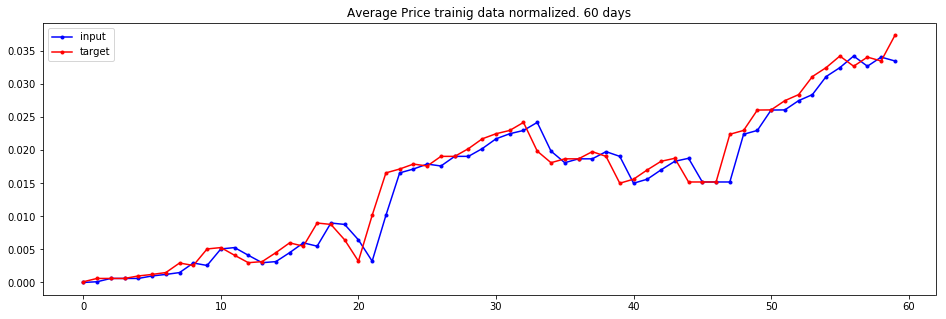

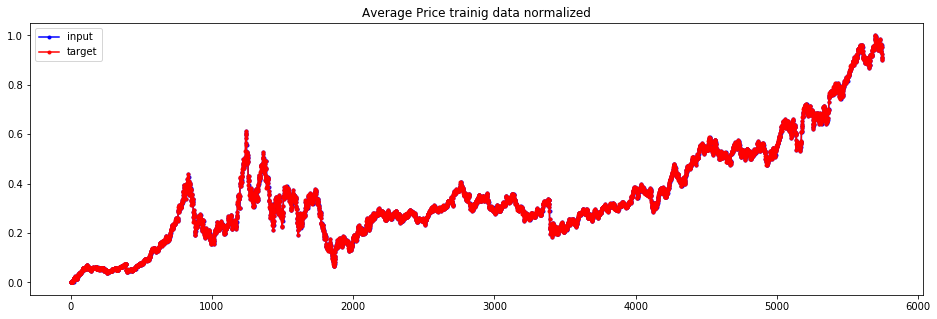

In [12]:
# Normalization of data
from pandas import Series
from sklearn.preprocessing import StandardScaler,MinMaxScaler

train_X = train_X_orig.copy()
train_y = train_y_orig.copy()
test_X  = test_X_orig.copy() 
test_y  = test_y_orig.copy() 

# We fit scalers using training data and then apply scaling to both training and test datasets
# We treat test data as we would never have seen it before

# scaler_price = StandardScaler()
scaler_price = MinMaxScaler()
scaler_price.fit(train_X[['AvgPrice']].values)

train_X[['AvgPrice']] = scaler_price.transform(train_X[['AvgPrice']])
train_y[['AvgPrice']] = scaler_price.transform(train_y[['AvgPrice']])

test_X[['AvgPrice']] = scaler_price.transform(test_X[['AvgPrice']])
test_y[['AvgPrice']] = scaler_price.transform(test_y[['AvgPrice']])

plot_data(train_X['AvgPrice'], train_y['AvgPrice'], "Average Price trainig data normalized. 60 days", 60)
plot_data(train_X['AvgPrice'], train_y['AvgPrice'], "Average Price trainig data normalized")

### Note! 
The plot of the test data below contains values higher than `1.0`.
This means that the test data set contains value that the network has never seen in the training.

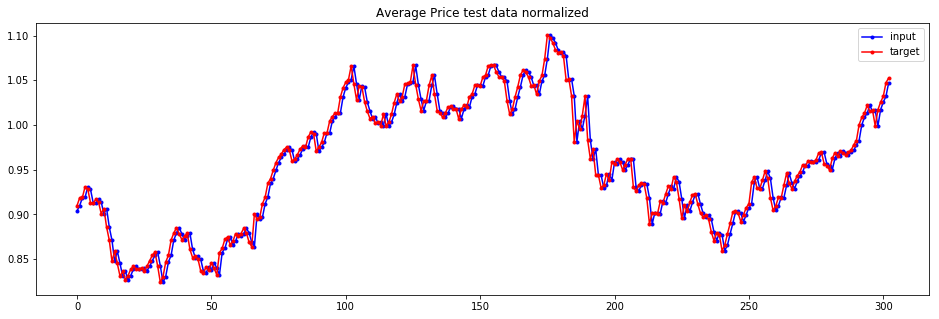

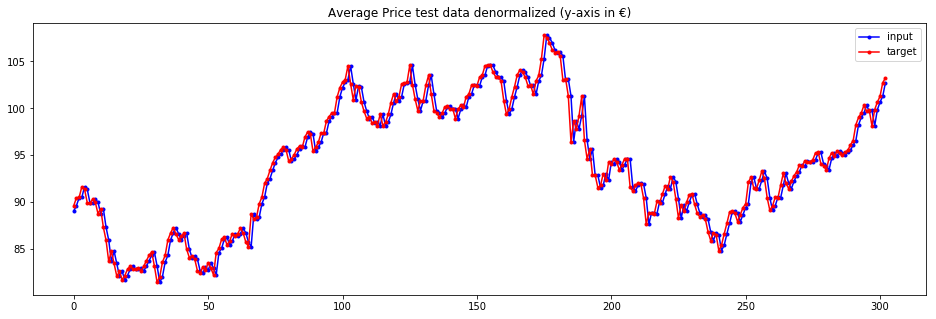

In [13]:
plot_data(test_X['AvgPrice'], test_y['AvgPrice'], "Average Price test data normalized")

# How to go back to the unscaled price/volume
denorm_X=scaler_price.inverse_transform(test_X[['AvgPrice']])
denorm_y=scaler_price.inverse_transform(test_y[['AvgPrice']])

plot_data(denorm_X, denorm_y, "Average Price test data denormalized (y-axis in €)")

Before we start with training, let's double-check if the input and target data are correctly reflected in arrays


In [14]:
print("Ideal prediction done at day 0:")
print(train_y[0:1])
print("Shoudl equal the average price from day 1:")
print(train_X[1:2])

print("\nThe same should hold for test data.")
print("Ideal prediction done at day 0:")
print(test_y[0:1])
print("Shoudl equal the average price from day 1:")
print(test_X[1:2])

Ideal prediction done at day 0:
   AvgPrice
0  0.000105
Shoudl equal the average price from day 1:
   AvgPrice
1  0.000105

The same should hold for test data.
Ideal prediction done at day 0:
      AvgPrice
5747  0.909809
Shoudl equal the average price from day 1:
      AvgPrice
5748  0.909809


## Section 1.5: Save the data

Training and test data are packed into a csv files.

In [15]:
data_dir = 'data'

pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join('data', 'train.csv'), header=False, index=False)


pd.concat([pd.DataFrame(test_y), pd.DataFrame(test_X)], axis=1) \
        .to_csv(os.path.join('data', 'test.csv'), header=False, index=False)

# Part 2: Local training and testing


## Section 2.1: Define a Neural Network Model

### Brief introduction

Neural network model can be seen as a Blackbox function that has inputs and outputs:

![Blackbox Neural Network](images/blackbox.jpg)

Each neural network has:
- a structure of its blackbox
- a set of parameters (weights) that configure the parts of its structure

Example of a network with unknown structure, but known input interface (a vector of 196608 values) and known output interface (3 values).

![Blackbox Neural Network cat example](images/neural-network-as-blackbox-3.jpg)


Process of training consists of setting the weights in such a way, so staht prediction error is minimized.

After the training is finished, the weights can be frozen and a trained model can be stored for use.

Using of the model consists of providing the input and reading the output.

- *Image 1 source: https://www.kdnuggets.com/2017/04/ai-machine-learning-black-boxes-transparency-accountability.html*
- *Image 2 source: https://www.learnopencv.com/neural-networks-a-30000-feet-view-for-beginners/*

### Model used in our case: LSTM

In our problem, we use a model consisting of LSTM (Long-short term memory) cells. **LSTM** is an example of recurrent neural network capable of learning long-term dependencies.

Recurrent neural networks allow to take parts of their outputs as inputs in order to learn fron the history and maintain a hidden state. The hidden state is a parametrized memory where the parameters describing the short-term memory and long-term memory can be learnt in the learning process.


We define the inputs and outpus of the model as follows:

- **Input** is a vector of past average stock prices. The length of this vector in configurable and will be called `batch_size`. It contains data from day `0` to day `batch_size - 1`. Today is `data[batch_size - 1]`
- **Output** is also a vector of `batch_size` including average stock prices. It contains predictions for each elements of the input vector that are shifted by `forecast_days`, so that predictions for today are located in `predictions[batch_size - 2]` and for tomorrow in `predictions[batch_size - 1]` (under assumption that `forecast_days = 1`).

The Network looks conceptually as presented in Figure 3. Brief comments about the components:
- In this diagram, time flows from left to right,
- `A` block is a LSTM cell that takes input `x` and the state of the previous cell (rigth arrow between `A` blocks),
- `h` is a hidden state, which is also an output of the LSTM layer,
- LSTM layers can be stacked, so that output vector `h` can be the input to the next layer placed on top

![RNN concept](images/RNN-unrolled.png)

- *Image 3 source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/*

### Note!

We do not intend to go into details of LSTM. This is a relatively complex component.

We want to show the training and deployment in the AWS environment provided that a definition of the network is given e.g., taken from from a paper.

If you want to read more about LSTM, navigate to the following resources:
- Understanding LSTM Networks:   [https://colah.github.io/posts/2015-08-Understanding-LSTMs/](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) 
- LSTM processing animations:  [https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) 

### Local training and testing

Before we use our model on AWS, we would like to try it locally to make sure that the implementation is bug-free and initial results are correct. For this, we will train and evaluate the model in this notebook.

First we will load the training data set to use. It may be time consuming to try and train the model completely in the notebook as we do not have access to a GPU and the compute instance that we are using is not particularly powerful. However, we can work on a portion the data to get a feel for how our training script is behaving.

(In this case, we will use entire data set, as the network that we use requires little computational power)

#### Model

The model is defined in `train/model.py` and the code looks as follows.

We se there the following elements:
- LSTM component, which can have multiple layers (parameter `self.num_layers`)
- Linear component that takes the output from LSTM (of size `self.hidden_dim`) and coverts it to the size `output_dim` which in our case is `1`
- function `init_hidden` that is responisble for initializing of the hidden layer in LSTM with zeros
- function `forward` that defines how to produce the `output` from the `input` to the network

In [16]:
!pygmentize train/model.py

import torch
import torch.nn as nn
from torch.autograd import Variable

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout=0.25)
        self.linear = nn.Linear(in_features=self.hidden_dim, out_features=output_dim)

    def init_hidden(self):
        # Initializes hidden layer with zeros
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))

    def forward(self, input_X):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
 

#### Read the training data and define size of the batch

In this block, we read the previously stored training data from a csv file.

We make sure that the number of samples from the training data set is a multiple of `batch_size`.

In [17]:
import torch
import torch.utils.data

batch_size = 50

# Read all data from file to calculate data length
dummy_read = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None)
num_rows_train = (len(dummy_read) // batch_size) * batch_size

# Read again so many rows, so that num_rows/batch_size is an integer
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=num_rows_train)

# Order of data in train.csv:
# Y-Average  |  X-Average  
# to_predict |  INPUT VALUE

# Turn the input in form of pandas.DataFrame into PyTorch Tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).float()

#print(train_sample)
print(train_sample_y.shape)
print(train_sample_X.shape)

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=batch_size)

torch.Size([5700])
torch.Size([5700, 1])


### Writing the training method and testing it locally

Next we need to write the training code itself. We train the network in **epochs** and **batches**.

In a single *epoch*, the entire train dataset is fed to the network. We use multiple epochs for learning, so that the network can learn it better.

In a single *batch* a subset of the trainig data is presented to the network. 

Longer the batch means usually:
- better prediction results 
- less usability (more input is required to use the network)

The code below is commented to understand the process a bit better.

In [18]:
import torch
from torch import nn
import torch.optim as optim

from train.model import LSTM
   
def train(model, train_loader, epochs, optimizer, criterion, device):
    
    # For storing the prediction error over epochs
    loss_trace = []
    
    for epoch in range(1, epochs + 1):
        
        # Set model to train mode - allow gradient calculation and thus learning
        model.train()
        total_loss = 0
        
        # Iterate over batches
        for batch in train_loader:
            batch_X, batch_y = batch
            # Move data to GPU if available to speed-up calculations
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Remove gradients from previous batches from the memory. Network has already learnt it
            model.zero_grad()
            
            # Obtain prediction for an input - run the `forward` function from the model definition
            output = model(batch_X)
           
            # Calculate prediction error a.k.a loss
            loss = criterion(output.squeeze(), batch_y)
            

            # Apply backpropagation step
            # Calculate corrections to the network, so that next time the error is (hopefully) smaller
            loss.backward()
            # Prevent `gradient explosion` phenomenon by clipping the gradients to a magic number
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            # Correct the weights of a network based on the corrections calculated previously
            # Here the learning takes place
            optimizer.step()
            
            # Collect prediction error for this batch
            total_loss += loss.data.item()
            
        print("Epoch: {}, MSELoss: {}".format(epoch, total_loss / len(train_loader)))
        loss_trace.append(total_loss)
    return model, loss_trace

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))
model = LSTM(input_dim=1, hidden_dim=64, batch_size=batch_size, output_dim=1, num_layers=2).to(device)

print(model)


optimizer = optim.Adam(model.parameters(), lr=0.0002)
loss_fn = torch.nn.MSELoss()

model, loss_trace = train(model, train_sample_dl, 30, optimizer, loss_fn, device)

Using device: cpu
LSTM(
  (lstm): LSTM(1, 64, num_layers=2, dropout=0.25)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 1, MSELoss: 0.07860316007941436
Epoch: 2, MSELoss: 0.03526528192378464
Epoch: 3, MSELoss: 0.036484871062975
Epoch: 4, MSELoss: 0.03739349703736432
Epoch: 5, MSELoss: 0.03627231943889791
Epoch: 6, MSELoss: 0.034965830673683196
Epoch: 7, MSELoss: 0.03353578239125853
Epoch: 8, MSELoss: 0.03177171948954582
Epoch: 9, MSELoss: 0.030087810636216187
Epoch: 10, MSELoss: 0.027941632511915247
Epoch: 11, MSELoss: 0.025676580096299865
Epoch: 12, MSELoss: 0.023049765545262123
Epoch: 13, MSELoss: 0.020053372962202207
Epoch: 14, MSELoss: 0.017018164050808225
Epoch: 15, MSELoss: 0.01376216996919666
Epoch: 16, MSELoss: 0.010618511742346496
Epoch: 17, MSELoss: 0.0077197416915288685
Epoch: 18, MSELoss: 0.005573929707711693
Epoch: 19, MSELoss: 0.003919149935347633
Epoch: 20, MSELoss: 0.0031408970734398615
Epoch: 21, MSELoss: 0.0025949229441865006
Epoch: 22, MSELos

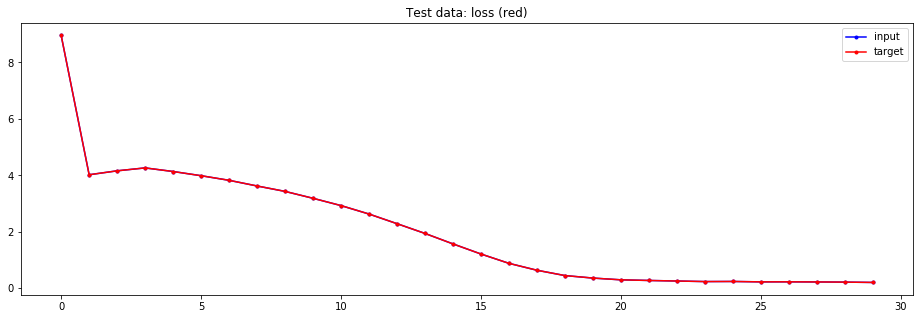

In [19]:
np_loss_trace = np.array(loss_trace).reshape(-1, 1)

plot_data(np_loss_trace, np_loss_trace, 
          "Test data: loss (red)", len(loss_trace))

Supposing we have the training method above, we will test that it is working by writing a bit of code in the notebook that executes our training method on the small sample training set that we loaded earlier. The reason for doing this in the notebook is so that we have an opportunity to fix any errors that arise early when they are easier to diagnose.

In [20]:
import torch
import torch.utils.data
from sklearn.metrics import mean_squared_error

test_dummy = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None, names=None)

num_rows_test = (len(test_dummy) // batch_size) * batch_size

test_sample = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None, names=None, nrows=num_rows_test)
test_y = torch.from_numpy(test_sample[[0]].values).float().squeeze()

test_X = torch.from_numpy(test_sample.drop([0], axis=1).values).float()

# Build the dataset
test_ds = torch.utils.data.TensorDataset(test_X, test_y)
# Build the dataloader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)




def test(model, test_loader, criterion, device):
    
    model.eval()
    
    data = dict()
    data['prediction'] = []
    data['expected'] = []

    total_loss = 0
    total_rmse = 0

    for batch in test_loader:
        batch_X, batch_y = batch
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
    
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        
        # Calculate errors - note copying data from GPU to CPU!
        flat_output = output.cpu().detach().numpy().reshape(-1,1)              
        flat_y = batch_y.cpu().detach().numpy()
        data['prediction'].append(flat_output)
        data['expected'].append(flat_y)
        total_rmse += mean_squared_error(flat_y, flat_output)
        total_loss += loss.data.item()

        
    print("test:mseloss: {}".format(total_loss / len(test_loader)))
    print("test:rmse: {}".format(total_rmse))
    return data

loss_fn = torch.nn.MSELoss()
result = test(model, test_dl, loss_fn, device)

test:mseloss: 0.00045414517808239907
test:rmse: 0.0027248710830463096


### Displaying prediction results

Note that Y-axis is still normalized and some values are $> 1$.
This means that they are `out of scale`, and the predictor will have problems with precise preodiction in such cases, because it have never seen such training data before.

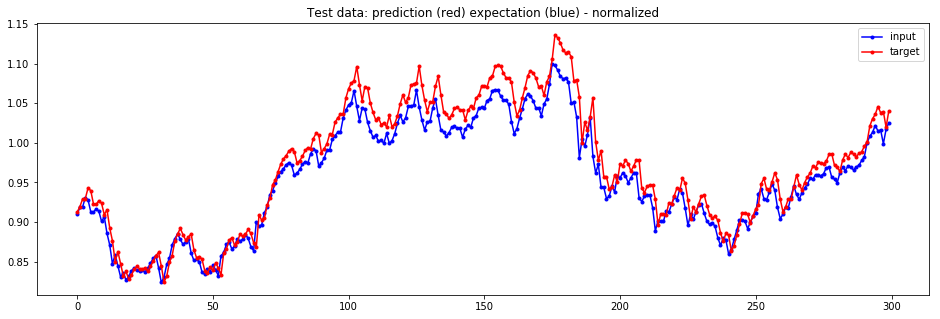

In [21]:
# Remove batching from result
predictions = []
for batch_arr in result['prediction']:
    for value in batch_arr:
        predictions.append(value)

expectations = []
for batch_arr in result['expected']:
    for value in batch_arr:
        expectations.append(value)

plot_data(np.array(expectations).reshape(-1, 1), 
          np.array(predictions).reshape(-1, 1), 
          "Test data: prediction (red) expectation (blue) - normalized", len(expectations))

### Invert scaling transformation

Let's look at the chart with Y-axis expressed in euro

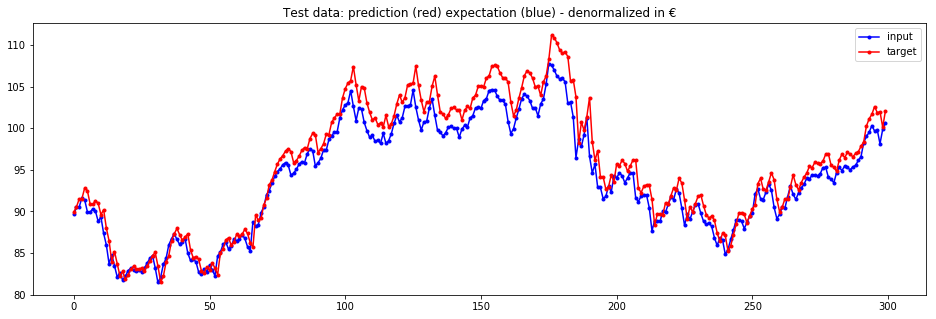

In [22]:
exp = scaler_price.inverse_transform(np.array(expectations).reshape(-1, 1))
pred = scaler_price.inverse_transform(np.array(predictions).reshape(-1, 1))

plot_data(exp, pred, "Test data: prediction (red) expectation (blue) - denormalized in €", len(expectations))

# Part 3: AWS

## Section 3.1: Prepare Custom Code for Training and Prediction

### Model as defined by Amazon SageMaker

In particular, a model comprises three objects

 - Model Artifacts (provided in `train/model.py`),
 - Training Code (provided in `train/train.py`),
 - Inference Code (also provided in `train/train.py`).
 
each of which interact with one another. Here we will still be using containers provided by Amazon with the added benefit of being able to include our own custom code.

You already have seen the model in `train/model.py`. Parts of the trainig code were also used for local training. 
Let's peek into the training and inference code defined in `train/train.py`.

In [23]:
!pygmentize train/train.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from sklearn.metrics import *

from model import LSTM

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTM(input_dim=1,
             hidden_dim=model_info['hidden_dim'], 
             batch_size=model_info['batch_size'],
             output_dim=1, 
             num_layers=model_info['num_layers']).to(device)

    # Load 

## Section 3.2: Uploading the training data to S3


Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [24]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/stock-predictor-dojo1'

role = sagemaker.get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-628201230330


We upload entire data directory containing `train.csv` and `test.csv` files.

In [25]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Section 3.3: Train the model on a separate GPU-enabled EC2 instance

In order to construct a PyTorch model using SageMaker we must provide SageMaker with a training script. We may optionally include a directory which will be copied to the container and from which our training code will be run. When the training container is executed it will check the uploaded directory (if there is one) for a `requirements.txt` file and install any required Python libraries, after which the training script will be run.

We may also configure the type of EC2 instance that will be used for training. Here, we use one of the `p2.*` instances, which are GPU-enabled. We want to minimize the time we use the `p2` instance, beacuse they are relatively expensive - cheapest one costs about $1 per hour.

from sagemaker.pytorch import PyTorch
Once a model is trained, we usually need much less computing power to use the model. Thus, we will later deploy the trained model on a weaker, non-GPU instance `m4.xlarge`.

In [26]:
from sagemaker.pytorch import PyTorch

instance_type_training = 'ml.p2.xlarge'
instance_type_deployment = 'ml.m4.xlarge'
# Must be a 'ml.*'instance, for example:
# - ml.m4.xlarge - new EC2 instance with CPU
# - ml.p2.xlarge - new EC2 instance with GPU

### Custom Metrics

We may define custom metrics that AWS will parse and present in CloudWatch.
The output from training based on a regular expression and present the data as a chart in CloudWatch.

In [27]:
# Custom metrics
metric_definitions = [{'Name': 'Training-Loss',
                       'Regex': 'train:mseloss: ([0-9\\.]+)'}]

### Defining an Estimator

Next, we define an `estimator` object with custom entry point (reference to our custom code) and optionally custom metrics definitions.

In [28]:
estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type=instance_type_training,
                    metric_definitions = metric_definitions,
                    hyperparameters={
                        'epochs': 50,
                        'hidden-dim': 640,
                        'batch-size': 50,
                        'num-layers': 4,
                        'learning-rate': 0.0001 # Keep not higher than 0.0002
                    })

### Training

Next, we instruct to fit the estimator. Fitting is a better term to describe model learning :)

In [29]:
# Training with given hyperparameters
estimator.fit({'training': input_data})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-628201230330
INFO:sagemaker:Creating training-job with name: sagemaker-pytorch-2019-04-02-10-45-13-007


2019-04-02 10:45:13 Starting - Starting the training job...
2019-04-02 10:45:14 Starting - Launching requested ML instances......
2019-04-02 10:46:22 Starting - Preparing the instances for training.........
2019-04-02 10:48:13 Downloading - Downloading input data...
2019-04-02 10:48:41 Training - Training image download completed. Training in progress..
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-04-02 10:48:42,510 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-04-02 10:48:42,542 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-04-02 10:48:42,550 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-04-02 10:48:42,810 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2019-04-02 10:48:42,810 sagemaker-containers INFO     Generating setup.cfg
2019-04-02 10:48:

Epoch: 3 train:mseloss: 0.045371777236588265
Epoch: 4 train:mseloss: 0.0401297820486402
Epoch: 5 train:mseloss: 0.035413570296026466
Epoch: 6 train:mseloss: 0.029535711295210876
Epoch: 7 train:mseloss: 0.02211513106764566
Epoch: 8 train:mseloss: 0.014196360242510165
Epoch: 9 train:mseloss: 0.007386804102951142
Epoch: 10 train:mseloss: 0.0036003583674691824
Epoch: 11 train:mseloss: 0.0019179269995156414
Epoch: 12 train:mseloss: 0.0012596944184782874
Epoch: 13 train:mseloss: 0.0010107267970804394
Epoch: 14 train:mseloss: 0.0008783106535255476
Epoch: 15 train:mseloss: 0.0007849300549296139
Epoch: 16 train:mseloss: 0.0006888977009670302
Epoch: 17 train:mseloss: 0.0006101419509688736
Epoch: 18 train:mseloss: 0.0006018964714920067
Epoch: 19 train:mseloss: 0.0005804601008557048
Epoch: 20 train:mseloss: 0.0005274950691321129
Epoch: 21 train:mseloss: 0.0004780749807475347
Epoch: 22 train:mseloss: 0.0004541887758118958
Epoch: 23 train:mseloss: 0.00042239857315220624
Epoch: 24 train:mseloss: 0.00

Note the `Billable seconds: XX` output -  this is the total cost of running the training instance. 
This allows to run powerful multi-GPU instances at the same time minimizing the AWS costs.

By navigating to trining jobs (https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs) one can see vaious details like: monitorig of resources usage, potential errors, etc.

The trained model is stored in S3, so that it can be deployed and used in a predictior predictor later.

## Section 3.4: Deploy the Trained Model on a Separate Instance

In order to use the model over a REST endpoint, we need to deploy it first.

Deployed predictior is a EC2 instance holding the trained model. 
It can be accessed via `endpoint`. All endpoints are listed under: https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints

In [30]:
# Deploy the trained model
predictor = estimator.deploy(initial_instance_count=1, 
                         instance_type=instance_type_deployment)

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2019-04-02-10-45-13-007
INFO:sagemaker:Creating endpoint with name sagemaker-pytorch-2019-04-02-10-45-13-007


---------------------------------------------------------------------------!

## Section 3.5: Use the Deployed Model for Predictions

Now the model is ready for use! Let's predict the price for tomorrow then!

Input to the predictor - scaled average prices from the last 50 days:
[0.92952932 0.92842674 0.93787744 0.94811569 0.94018761 0.91855602
 0.90443248 0.90963036 0.91902855 0.91824099 0.93231203 0.94570051
 0.93488472 0.92874177 0.93703738 0.94323283 0.94759065 0.95536122
 0.95383861 0.95982405 0.95903649 0.95845895 0.96124165 0.96885471
 0.96916974 0.9564113  0.95425864 0.9495858  0.96250175 0.96895972
 0.96512694 0.97084986 0.96906473 0.9659145  0.96974728 0.97153241
 0.97778037 0.98255822 1.00019951 1.00833761 1.01316797 1.02188361
 1.01511061 1.01626569 0.99888692 1.01705325 1.02550637 1.03201685
 1.04724297 1.05249336]
Based on the trend from the last 50 days, the price tomorrow will be: 102.47349548339844


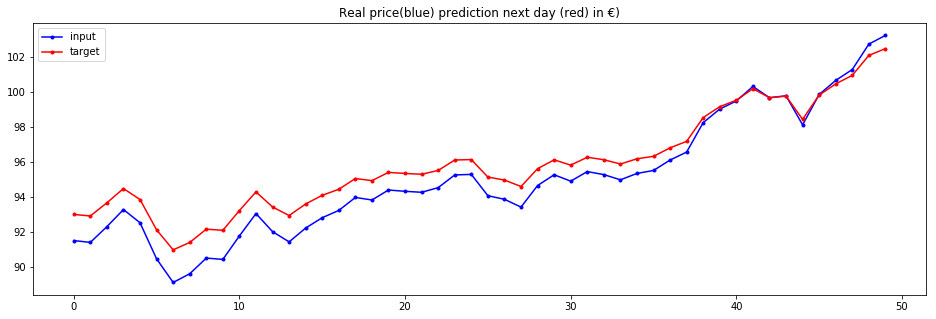

In [31]:
# Let's get prices of SAP stocks from the last batch_size days
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None, names=None)
test_avg_price = np.array(test_data[0])

# Slice the last batch_size days out of the test data
input_1 = np.array(test_avg_price[-1*batch_size:])

print("Input to the predictor - scaled average prices from the last {} days:\n{}".format(batch_size,input_1))

# Predict the prices
result = predictor.predict(input_1)

# Change the shape of the result from (1,X,1) to (X,1)
result = np.array(result).reshape(-1, 1)

# Denormalize the data, i.e., convert back to euro:
scaled_result = scaler_price.inverse_transform(result[-1:]).item()
print("Based on the trend from the last {} days, the price tomorrow will be: {}".format(batch_size, scaled_result))

input_scaled = scaler_price.inverse_transform(input_1.reshape(-1, 1))
result_scaled = scaler_price.inverse_transform(result)

plot_data(input_scaled, result_scaled, "Real price(blue) prediction next day (red) in €)", len(input_1))


### Testing the deployed model on the test data set

Now, let's provide all batches from the test data set as input and analyze the prediction quality.

Note, that we provide the network with the data that has not been used in training.

In [32]:
def predict(data, rows=batch_size):
    predictions = np.array([])
    
    batched = data.view(-1, batch_size)
    for batch in batched:
        result = predictor.predict(batch)
        npr = np.array(result)
        predictions = np.append(predictions, npr)
    
    return predictions

In [33]:
# Test using all batches from the testing data set
predictions = predict(test_X, batch_size)
predictions = [num for num in np.array(predictions)]

In [34]:
from sklearn.metrics import mean_squared_error

print("mean_squared_error: ", mean_squared_error(test_y, np.array(predictions)))

mean_squared_error:  0.00035313716548528146


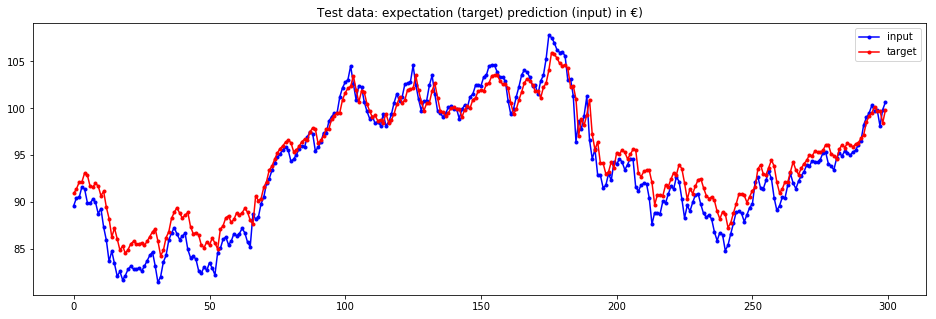

In [35]:
target_scaled = scaler_price.inverse_transform(test_y.numpy().reshape(-1, 1))
result_scaled = scaler_price.inverse_transform(np.array(predictions).reshape(-1, 1))

plot_data(target_scaled, result_scaled, "Test data: expectation (target) prediction (input) in €)", len(test_y))


### Testing the deployed model on the **training** data set

We may check if the model really well learned the data that was used for training.
We expect here a bit of overfitting (learning the training data), so the prediction should be much better here.

mean_squared_error:  0.00016508882780581777


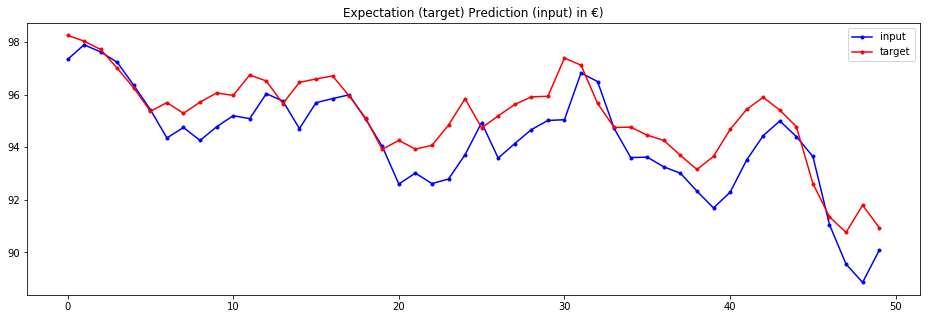

In [36]:
# Check how the predictor performs on the original training set (expect: overfitting)

train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None)
train_avg_price = np.array(train_data[0])
train_expectation = np.array(train_data[1])


input_2 = np.array(train_avg_price[-1*batch_size:])
train_expectation = np.array(train_expectation[-1*batch_size:].reshape(-1,1))

predictions_train = predictor.predict(input_2)
predictions_train = [num for num in np.array(predictions_train)]
predictions_train = np.array(predictions_train).reshape(-1,1)


print("mean_squared_error: ", mean_squared_error(train_expectation, predictions_train))

target_scaled_train = scaler_price.inverse_transform(train_expectation)
result_scaled_train = scaler_price.inverse_transform(predictions_train)

plot_data(target_scaled_train, result_scaled_train, "Expectation (target) Prediction (input) in €)", len(test_y))

In [37]:
# If you forget to delete the endpoint, the EC2 instace will keep running and generating costs
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-pytorch-2019-04-02-10-45-13-007
INFO:sagemaker:Deleting endpoint with name: sagemaker-pytorch-2019-04-02-10-45-13-007
